In [44]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pyBigWig
source='data/source/'

In [209]:
h=pd.read_pickle('data/h.pkl')
h=h[h['bl']==0]
print(h.shape)
#h['ez']=h[['ez1','ez2']].min(1)
#h=h.sort_values('ez',ascending=False)
h.head(10)

(37919, 10)


,ch,b,e,d,r,rd,suz,ez1,ez2,bl
14548,chr16,35540198,35543133,2935,"{35542016, 35542020, 35542534, 35542023, 35541...",170,1.57904,4.26666,4.78787,0
5901,chr11,82930138,82933554,3416,"{82931712, 82931720, 82931724, 82931729, 82931...",487,1.49445,3.61212,4.20912,0
21369,chr2,118702071,118704629,2558,"{118703616, 118704131, 118702596, 118704133, 1...",204,1.43805,4.04848,4.65634,0
21150,chr2,93641813,93643793,1980,"{93642752, 93643272, 93643792, 93643287, 93642...",140,1.43805,4.00000,4.41958,0
6413,chr11,98326745,98329952,3207,"{98327552, 98329602, 98329604, 98327044, 98328...",246,1.40985,4.65454,5.76123,0
22806,chr2,181670295,181672137,1842,"{181670912, 181671425, 181670914, 181670408, 1...",153,1.40985,3.70909,3.78821,0
26257,chr4,124656447,124660196,3749,"{124657668, 124657671, 124657674, 124657677, 1...",376,1.38166,3.27272,3.63037,0
28166,chr5,33721373,33724201,2828,"{33722369, 33723907, 33722371, 33723397, 33723...",227,1.35346,3.24848,4.47219,0
10824,chr14,21982490,21992024,9534,"{21989385, 21983241, 21991433, 21983246, 21987...",514,1.32526,3.63636,4.31435,0
37937,chr9,63135302,63150517,15215,"{63148032, 63141894, 63150086, 63143942, 63145...",707,1.32526,4.02424,4.81418,0


In [151]:
h[h.ch=='chr7'].head(1)

,ch,b,e,d,r,rd,suz,ez1,ez2,bl
34815,chr7,137309054,137315812,6758,"{137310208, 137314313, 137310232, 137314328, 1...",475,1.12788,4.04848,4.97202,0


In [27]:
hg=h.groupby('ch')['r'].apply(list)
hg=hg.apply(lambda x:set.union(*x))

In [28]:
rrbs='https://ftp.ncbi.nlm.nih.gov/geo/series/GSE120nnn/GSE120137/matrix/GSE120137-GPL21103_series_matrix.txt.gz'
age=pd.read_table(rrbs,skiprows=31).T
age=age.drop('!Sample_title')
age['age']=age[10].str[5:].str[:-2].astype(float)
age['id']=age.index.str[-3:]

In [29]:
fs=glob.glob('data/meth/GSE120137/l/*.txt')
def get_meth(fs):
    ps={}
    fs.sort()
    print(len(fs))
    n=7
    dfs=[]
    for sn in fs:
        name=sn.split('SH')[1][:3]
        print(name,end=',')
        df=pd.read_table(sn,engine='c',sep=' ',header=None,nrows=10**n)
        df=df[df[0].isin(hg.index)]
        df['hmr']=df.apply(lambda x:x[2]-1 in hg[x[0]],axis=1)
        df=df[df['hmr']][[0,2,5]]
        df.index=df[0].str[3:5]+'_'+(df[2]-1).astype(str)
        #h[name]=h.apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)
        dfs.append(df[5].rename(name))

In [339]:
hzs=[]
for i,rr in hz.iterrows():
    for r in list(rr['r']):
        hzs.append(rr['ch'][3:5]+'_'+str(r))
len(hzs)

27125

In [340]:
for c in ['l']:#['m','a','k','l','u','b']:
    fs=glob.glob('data/meth/GSE120137/'+c+'/csv/*.csv')
    dfs=[]
    for f in fs:
        print ('',end=',')
        df=pd.read_csv(f,index_col=0)
        df=df[df.index.isin(hzs)]
        dfs.append(df)
    df=dfs[0].merge(dfs[1],left_index=True,right_index=True,how='outer')
    for i in range(2,len(dfs)):
        print(i,end=',')
        df=df.merge(dfs[i],left_index=True,right_index=True,how='outer')
    df.shape
    p=df.mean()
    p=p.rename('DNAm')
    ps[c]=age[['id','age']].drop_duplicates().merge(p,left_on='id',right_index=True)    

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,

In [ ]:
ps['m']['Tissue']='Muscle'
ps['a']['Tissue']='Adipose'
ps['k']['Tissue']='Kidney'
ps['l']['Tissue']='Liver'
ps['u']['Tissue']='Lung'
ps['b']['Tissue']='Blood'
ps['bb']=ps['b'][ps['b'].age.isin([2,10,20])]
del ps['b']

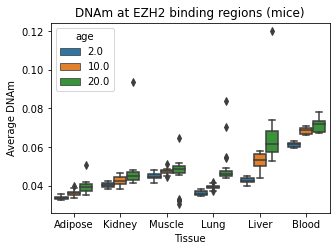

In [342]:
fig, ax = plt.subplots(figsize=(5,3.5))
ax=sns.boxplot(data=pd.concat(ps),x='Tissue',y='DNAm',hue='age'
            ,order=['Adipose','Kidney','Muscle','Lung','Liver','Blood']);
ax.set(title='DNAm at EZH2 binding regions (mice)',ylabel='Average DNAm');

In [215]:
for sn in fs:
    print(sn,end=',')
    path='data/meth/l/'+sn+'.bw'
    bw=pyBigWig.open(path)
    h[sn]=h.apply(lambda x: bw.stats(x['ch'],x['b'],x['e'],'mean',exact=True)[0],axis=1)

SRR4473855,SRR4473856,SRR4473857,SRR4473858,SRR4473859,SRR4473860,SRR4473861,SRR4473862,SRR4473863,SRR4473864,SRR4473865,SRR4473866,SRR4473867,SRR4473868,SRR4473869,SRR4473870,

In [ ]:
h['suz']=h.suz/h.suz.max()
h['ez1']=h.ez1/h.ez1.max()
h['ez2']=h.ez2/h.ez2.max()
h['ez']=h[['ez1','ez2']].mean(1)
h['prc']=h[['ez','suz']].mean(1)

In [337]:
hz=h.sort_values('prc',ascending=False).head(100)

In [331]:
fs=['SRR44738'+str(i) for i in range(55,71)]
for sn in fs:
    hz['w'+sn]=hz['rd']*hz[sn]

1000


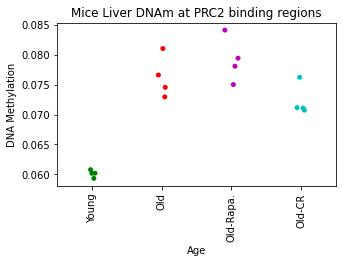

In [332]:
print(len(hz))
p=pd.DataFrame(hz[[f for f in fs]].mean())
p['Age']=4*['Young']+4*['Old']+4*['Old-Rapa.']+4*['Old-CR']
#p.columns=['Average DNAm','Passage']#,'Condition','Individual']
fig, ax = plt.subplots(figsize=(5,3))
ax=sns.stripplot(data=p,x='Age',y=0,palette=['g','r','m','c'])
ax.set( ylabel='DNA Methylation',title='Mice Liver DNAm at PRC2 binding regions')
ax.tick_params(axis='x', rotation=90)